In [1]:
from helpers import get_client, get_data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
from matplotlib.lines import Line2D

In [2]:
es = get_client()  
down_data = get_data("aggregated-curr-httpgetmt-*", es)
up_data   = get_data("aggregated-curr-httppostmt-*", es)

for df in (down_data, up_data):
    df['date'] = pd.to_datetime(df['date'])

Connected to Elasticsearch.


In [3]:
down2023 = down_data[down_data['date'].dt.year == 2023]
down2023.head()

,unit_id,operator_name,operator_technology,adv_download_speed,adv_upload_speed,bytes_sec,bytes_sec_interval,throughput,throughput_interval,date
139,40730037,CenturyLink,DSL,20.0,1.5,2.466300e+06,2.466300e+06,18.816377,18.816377,2023-01-01 00:00:00+00:00
140,80307653,CenturyLink,DSL,0.0,0.0,4.971455e+06,4.971455e+06,37.929190,37.929190,2023-02-01 00:00:00+00:00
141,79506577,Optimum,Cable,0.0,0.0,8.010080e+07,8.010080e+07,611.120569,611.120569,2023-04-01 00:00:00+00:00
142,216718,Charter,Cable,200.0,10.0,4.773453e+07,4.773453e+07,364.185558,364.185558,2023-05-01 00:00:00+00:00
143,79301317,None,None,NaN,NaN,4.034665e+06,4.034665e+06,30.782053,30.782053,2023-06-01 00:00:00+00:00


In [4]:
up2023 = up_data[up_data['date'].dt.year == 2023]
up2023.head()

,unit_id,operator_name,operator_technology,adv_download_speed,adv_upload_speed,bytes_sec,bytes_sec_interval,throughput,throughput_interval,date
137,3898665,[Verizon],Fiber,0.0,0.0,3.677673e+05,3.677673e+05,2.805842,2.805842,2023-01-01 00:00:00+00:00
138,613972,[Optimum],Cable,100.0,35.0,2.577931e+06,2.577931e+06,19.668051,19.668051,2023-02-01 00:00:00+00:00
139,1006746,[Comcast],Cable,400.0,10.0,2.910265e+06,2.910265e+06,22.203556,22.203556,2023-04-01 00:00:00+00:00
140,942822,[Charter],Cable,200.0,10.0,3.970574e+07,3.970574e+07,302.930741,302.930741,2023-05-01 00:00:00+00:00
141,1000748,[Cincinnati Bell],DSL,50.0,3.0,3.897049e+06,3.897049e+06,29.732122,29.732122,2023-06-01 00:00:00+00:00


In [29]:
def plot_speed_by_tech(data, direc):

    df = data.copy()
    df['date'] = pd.to_datetime(df['date'])
    df['month'] = df['date'].dt.month

    percentiles = [1, 10, 25]
    categories = ['Overall', 'Fiber', 'Cable', 'DSL']

    # 3) Shared palette
    palette = dict(zip(
        percentiles,
        sns.color_palette('tab10', n_colors=len(percentiles))
    ))

    # 4) Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
    axes = axes.flatten()

    for ax, cat in zip(axes, categories):
        sub = df if cat == 'Overall' else df[df['operator_technology'] == cat]
        title = 'All Technologies' if cat == 'Overall' else cat

        quantiles = (
            sub
            .groupby('month')['throughput']
            .quantile([p/100 for p in percentiles])
            .unstack()
        )

        for p in percentiles:
            sns.lineplot(
                x=quantiles.index,
                y=quantiles[p/100],
                marker='o',
                linestyle='-',
                color=palette[p],
                ax=ax,
                label=None,
                sort=False
            )

        ax.set_title(title)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xticks(quantiles.index)
        ax.set_xticklabels(
            [pd.to_datetime(m, format='%m').strftime('%b') for m in quantiles.index]
        )
        ax.grid(axis='x', linestyle='--', alpha=0.7)
        ax.grid(axis='y', linestyle='--', alpha=0.7)

    # 5) Shared labels and title
    fig.suptitle(f'Low Performance Throughput Quartiles by Technology ({direc}) [01/2023 - 07/2023]', fontsize=16, y=0.95)
    fig.supxlabel('Month')
    fig.supylabel('Throughput (Mbps)')

    # 6) Common legend in upper right
    handles = [Line2D([0], [0], color=palette[p], marker='o', linestyle='-') for p in percentiles]
    labels  = [f'{p}th percentile' if p>1 else f'{p}st percentile' for p in percentiles]
    fig.legend(
        handles, labels, loc='upper right', bbox_to_anchor=(0.98, 0.98),
    )

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # make room for suptitle
    plt.savefig(f'./plots/low_perf_quartiles/speed_{direc}.png', dpi=600)
    plt.show()


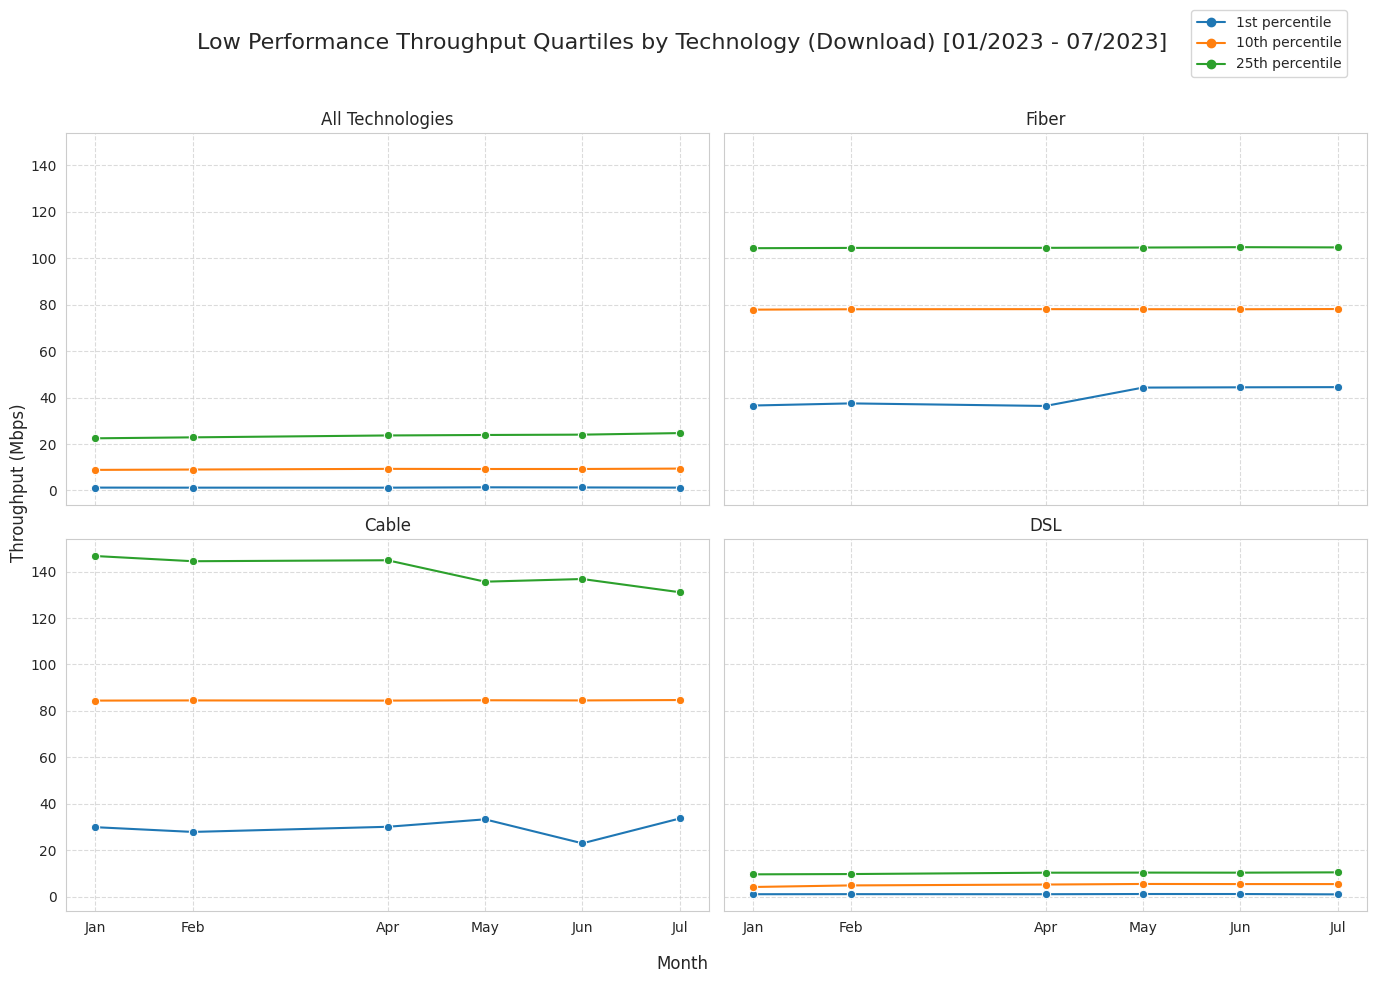

In [30]:
plot_speed_by_tech(down2023, 'Download')

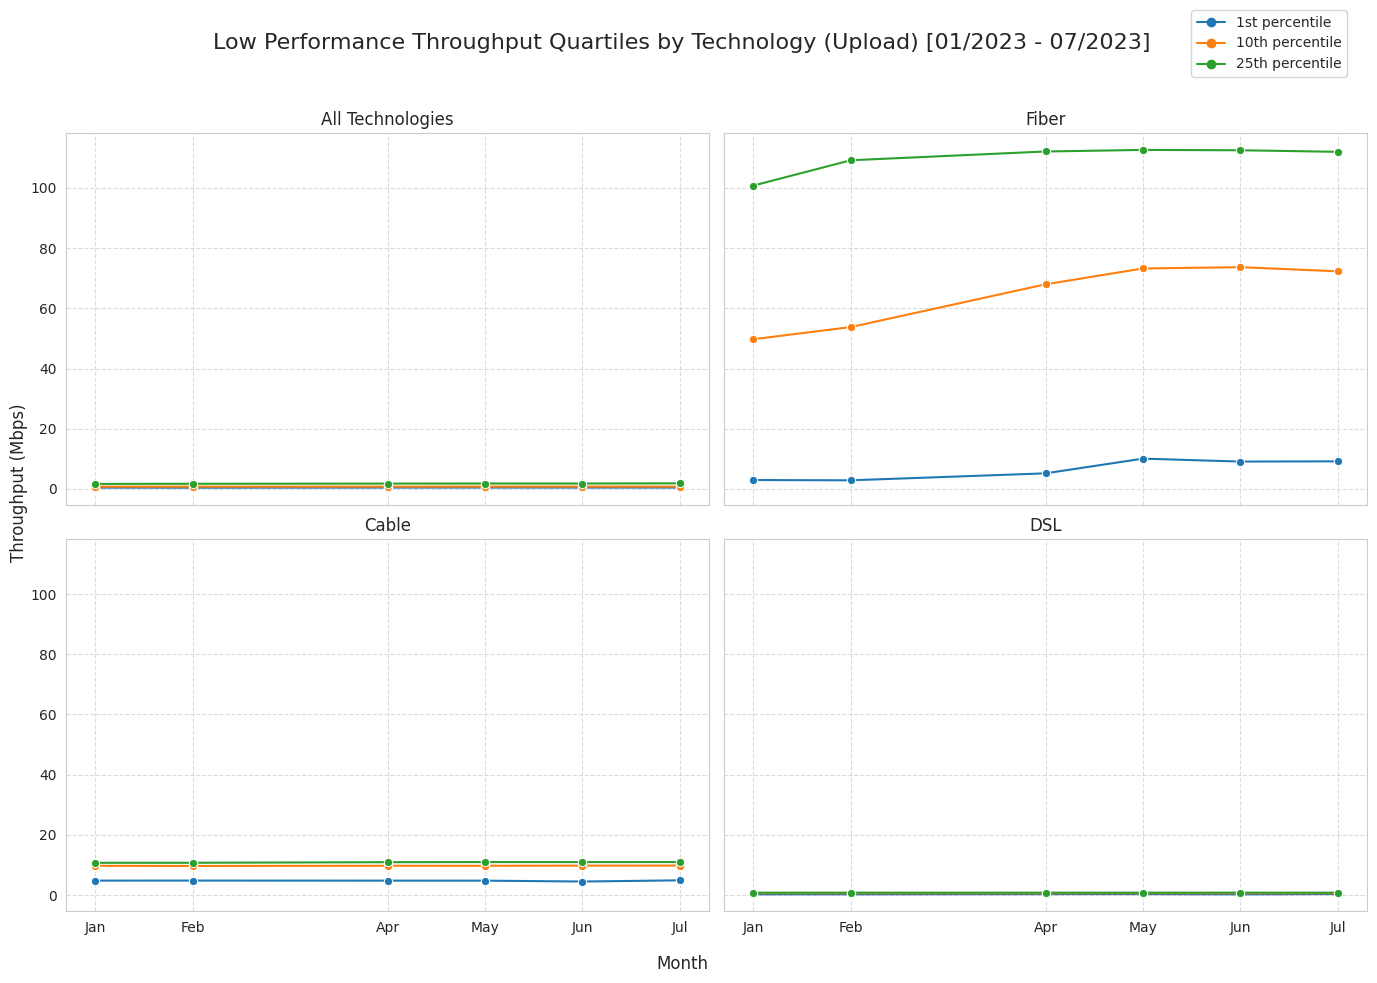

In [31]:
plot_speed_by_tech(up2023, 'Upload')